**Description**: Tries to answer [my answer on
stats.stackexchange.com](https://stats.stackexchange.com/q/611877/337906) by training
BERT on real classification datasets. This experiment suggests that training on test set
features (no labels) can be okay.

**Estimated runtime**: ~30 minutes on a Google Colab GPU or TPU. Eternity on CPU.

In [ ]:
!python -m pip install datasets transformers[torch]

In [ ]:
from __future__ import annotations

from datasets import load_dataset
from IPython.display import clear_output
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    BertForSequenceClassification,
    DataCollatorForLanguageModeling,
    logging,
    Trainer,
    TrainingArguments,
)

In [ ]:
logging.set_verbosity_error()
# ignore the HF warning about untrained weights

In [ ]:
assert torch.cuda.is_available(), "This notebook needs to run on a GPU"

# Load dataset

In [ ]:
# DATASET_NAME = "ag_news"  # mostly causal. may have an anti-causal effect
# DATASET_NAME = "SetFit/amazon_counterfactual_en"  # causal
# DATASET_NAME = "SetFit/enron_spam"  # causal
# DATASET_NAME = "yelp_review_full"  # unclear. may have an anti-causal effect

# DATASET_NAME = "dair-ai/emotion"
# DATASET_NAME = "ethos"  # load w/ "binary"
# DATASET_NAME = "yahoo_answers_topics"
# DATASET_NAME = "trec"
# DATASET_NAME = "mteb/mtop_domain"
# DATASET_NAME = "christinacdl/clickbait_notclickbait_dataset"
# DATASET_NAME = "financial_phrasebank"  # load w/ "sentences_allagree"
# DATASET_NAME = "app_reviews"
DATASET_NAME = "rotten_tomatoes"

In [ ]:
df = pd.DataFrame(load_dataset(DATASET_NAME, split="train"))

In [ ]:
df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [ ]:
if DATASET_NAME == "yahoo_answers_topics":
    df["text"] = df["question_title"].str.cat(df["question_content"], sep="\n")
    df["label"] = df["topic"]
elif DATASET_NAME == "trec":
    df["label"] = df["coarse_label"]
elif DATASET_NAME == "financial_phrasebank":
    df["text"] = df["sentence"]
elif DATASET_NAME == "app_reviews":
    df["text"] = df["review"]
    df["label"] = df["star"] - 1

Ensure your dataframe passes these checks

In [ ]:
assert len(set(df.index)) == len(df)
assert "text" in df.columns
assert "label" in df.columns
# please assign a new column if the test fails

In [ ]:
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

In [ ]:
df["label"].value_counts(normalize=True).sort_index()

0    0.2
1    0.2
2    0.2
3    0.2
4    0.2
Name: label, dtype: float64

# Download model

In [ ]:
_ = BertForMaskedLM.from_pretrained("bert-base-uncased")
# just downloading it to your comp if it hasn't already been downloaded
del _
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# MLM

In [ ]:
class TokenizedSentencesDataset(Dataset):
    """
    taken from https://github.com/UKPLab/sentence-transformers/blob/master/examples/unsupervised_learning/MLM/train_mlm.py
    """

    def __init__(self, sentences, tokenizer, max_length, cache_tokenization=False):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.max_length = max_length
        self.cache_tokenization = cache_tokenization

    def __getitem__(self, item):
        if not self.cache_tokenization:
            return self.tokenizer(
                self.sentences[item],
                add_special_tokens=True,
                truncation=True,
                max_length=self.max_length,
                return_special_tokens_mask=True,
            )

        if isinstance(self.sentences[item], str):
            self.sentences[item] = self.tokenizer(
                self.sentences[item],
                add_special_tokens=True,
                truncation=True,
                max_length=self.max_length,
                return_special_tokens_mask=True,
            )
        return self.sentences[item]

    def __len__(self):
        return len(self.sentences)

In [ ]:
def bert_pretrain(texts: list[str], output_dir: str = "./pretrained_bert"):
    """
    Saves a fresh BERT model which is trained on `texts` to `output_dir` using masked
    language modeling loss.

    It can be loaded for other tasks using, for example::

        from transformers import BertForSequenceClassification
        model = BertForSequenceClassification.from_pretrained(output_dir)
    """
    # Set up data
    train_dataset = TokenizedSentencesDataset(texts, tokenizer, max_length=100)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=True, mlm_probability=0.15
    )

    # Set up Trainer
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        learning_rate=1e-4,
        num_train_epochs=2,
        per_device_train_batch_size=64,
        save_strategy="no",
        optim="adamw_torch",
        prediction_loss_only=True,
        disable_tqdm=False,
    )

    # Trainer will modify this model, so need to re-load a fresh one every time
    # this function is called
    trainer = Trainer(
        model=BertForMaskedLM.from_pretrained("bert-base-uncased").to("cuda"),
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
    )

    trainer.train()
    trainer.save_model()

# Classification

In [ ]:
class TextClassificationDataset(torch.utils.data.Dataset):
    """
    taken from https://huggingface.co/transformers/v3.2.0/custom_datasets.html#sequence-classification-with-imdb-reviews
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def _classification_dataset(
    texts: list[str], labels: list[int]
) -> TextClassificationDataset:
    encodings = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    labels = torch.tensor(labels)
    return TextClassificationDataset(encodings, labels)

In [ ]:
def bert_finetune_classification(
    texts: list[str],
    labels: list[int],
    num_labels: int,
    pretrained_model_name_or_path: str = "./pretrained_bert",
) -> Trainer:
    """
    Returns a BERT model `Trainer` which was finetuned on classification data
    `texts, labels`.
    """
    train_dataset = _classification_dataset(texts, labels)
    classifier_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        optim="adamw_torch",
        disable_tqdm=False,
    )
    classifier_trainer = Trainer(
        model=(
            BertForSequenceClassification.from_pretrained(
                pretrained_model_name_or_path, num_labels=num_labels
            ).to("cuda")
        ),
        args=classifier_args,
        train_dataset=train_dataset,
    )
    classifier_trainer.train()
    return classifier_trainer

In [ ]:
def classifier_accuracy(
    texts: list[str], labels: list[int], trained_classifier: Trainer
) -> float:
    """
    Returns the accuracy of `trained_classifier` on `texts` by comparing its
    predictions to `labels`.
    """
    eval_dataset = _classification_dataset(texts, labels)
    pred_out = trained_classifier.predict(eval_dataset)
    preds = pred_out.predictions.argmax(axis=1)
    return (preds == labels).mean()

# Experiment

In [ ]:
def _stratified_sample(
    df: pd.DataFrame, sample_size: int, random_state: int = None
) -> pd.DataFrame:
    # let's not worry about not exactly returning a df w/ size sample_size for
    # now. it's nbd for this experiment
    num_labels = len(set(df["label"]))
    num_obs_per_label = int(sample_size / num_labels)

    def label_sampler(df_label: pd.DataFrame) -> pd.DataFrame:
        return df_label.sample(num_obs_per_label, random_state=random_state)

    return df.groupby("label", group_keys=False).apply(label_sampler)


def _split(
    df: pd.DataFrame,
    num_train: int = 100,
    num_test: int = 200,
    random_state: int = None,
    stratified_train: bool = True,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns 3 (non-overlapping) dataframes which are randomly subsampled from
    `df`. The first has `num_train` rows, and the last two have `num_test` rows
    each.
    """
    if stratified_train:
        df_train = _stratified_sample(df, num_train, random_state=random_state)
    else:
        df_train = df.sample(num_train, random_state=random_state)

    random_state = None if random_state is None else random_state + 1
    df_extra, df_test = train_test_split(
        df.drop(df_train.index),
        train_size=num_test,
        test_size=num_test,
        random_state=random_state,
    )
    return df_train, df_extra, df_test

In [ ]:
def experiment_loop(
    df: pd.DataFrame,
    num_train: int = 100,
    num_test: int = 200,
    stratified_train: bool = True,
    random_state: int = None,
):
    df_train, df_extra, df_test = _split(
        df,
        num_train=num_train,
        num_test=num_test,
        stratified_train=stratified_train,
        random_state=random_state,
    )

    num_labels = len(set(df["label"]))  # configure output dim of linear layer

    # Run the methodology which does no pretraining. We'll compare to this data
    # to demonstrate that pretraining/domain adaptation helps, so that there's an effect
    # to detect
    print("Base - training classifier")
    trained_classifier = bert_finetune_classification(
        df_train["text"].tolist(),
        df_train["label"].tolist(),
        num_labels=num_labels,
        pretrained_model_name_or_path="bert-base-uncased",
    )
    print("Base - testing")
    base_accuracy = classifier_accuracy(
        df_test["text"].tolist(), df_test["label"].tolist(), trained_classifier
    )

    # Run the (presumably) fair pretraining methodology
    print("Extra - pretraining")
    bert_pretrain(df_extra["text"].tolist())  # overwrites ./pretrained_bert
    print("Extra - training")
    trained_classifier = bert_finetune_classification(
        df_train["text"].tolist(),
        df_train["label"].tolist(),
        num_labels=num_labels,
        pretrained_model_name_or_path="./pretrained_bert",
    )
    print("Extra - testing")
    extra_accuracy = classifier_accuracy(
        df_test["text"].tolist(), df_test["label"].tolist(), trained_classifier
    )

    # Run the (presumably) unfair pretraining methodology
    print("Test - pretraining")
    bert_pretrain(df_test["text"].tolist())  # overwrites ./pretrained_bert
    print("Test - training")
    trained_classifier = bert_finetune_classification(
        df_train["text"].tolist(),
        df_train["label"].tolist(),
        num_labels=num_labels,
        pretrained_model_name_or_path="./pretrained_bert",
    )
    print("Test - testing")
    test_accuracy = classifier_accuracy(
        df_test["text"].tolist(), df_test["label"].tolist(), trained_classifier
    )

    return base_accuracy, extra_accuracy, test_accuracy  # paired data

In [ ]:
num_trials = 30

base_accuracies = []
extra_accuracies = []
test_accuracies = []

for i in range(num_trials):
    clear_output(wait=True)
    print(f"Running trial {i+1} of {num_trials}\n")
    base_accuracy, extra_accuracy, test_accuracy = experiment_loop(
        df, random_state=42 + i
    )
    base_accuracies.append(base_accuracy)
    extra_accuracies.append(extra_accuracy)
    test_accuracies.append(test_accuracy)

Running trial 30 of 30

Base - training classifier


Step,Training Loss


Base - testing


Extra - pretraining


Step,Training Loss


Extra - training


Step,Training Loss


Extra - testing


Test - pretraining


Step,Training Loss


Test - training


Step,Training Loss


Test - testing


In [ ]:
# save results to csv
dataset_name = DATASET_NAME.split("/")[-1]  # remove owner
file_name = f"{dataset_name}.csv"
pd.DataFrame(
    {"base": base_accuracies, "extra": extra_accuracies, "test": test_accuracies}
).to_csv(file_name, index=False)

# Analysis

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import permutation_test
from statsmodels.stats.multitest import fdrcorrection

In [2]:
# dataset = "ag_news"
# dataset = "enron_spam"
# dataset = "amazon_counterfactual_en"
# dataset = "yelp_review_full"
# dataset = "craigslist_bargains"
# dataset = "emotion"
# dataset = "ethos"
# dataset = "yahoo_answers_topics"
# dataset = "trec"
# dataset = "mtop_domain"
# dataset = "clickbait_notclickbait_dataset"
# dataset = "financial_phrasebank"
# dataset = "app_reviews"
dataset = "rotten_tomatoes"

df = pd.read_csv(os.path.join("bert_accuracies", f"{dataset}.csv"))
print(df.describe().round(3))

         base   extra    test
count  30.000  30.000  30.000
mean    0.711   0.759   0.752
std     0.071   0.055   0.066
min     0.545   0.620   0.610
25%     0.659   0.728   0.711
50%     0.722   0.768   0.755
75%     0.754   0.784   0.799
max     0.830   0.875   0.875


In [3]:
permutation_test(
    data=(df["extra"], df["test"]),
    statistic=lambda x, y: np.mean(x - y),
    alternative="less",  # extra acc (fair) < test acc (unfair)
    permutation_type="samples",  # paired observations
    n_resamples=10_000,
).pvalue

0.7085291470852915

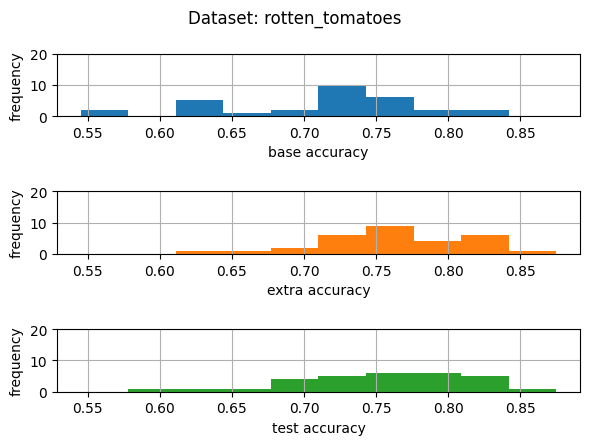

In [4]:
bins = 10

fig, axes = plt.subplots(
    nrows=len(df.columns), ncols=1, figsize=(6, len(df.columns) * 1.5)
)

axes: list[plt.Axes]

x_common_min = df.min().min()
x_common_max = df.max().max()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Plot histograms for each column
for i, column in enumerate(df.columns):
    column: str
    df[column].hist(
        bins=bins, ax=axes[i], range=(x_common_min, x_common_max), color=colors[i]
    )
    axes[i].set_ylim((0, 20))
    axes[i].set_xlabel(f"{column} accuracy")
    axes[i].set_ylabel("frequency")

fig.suptitle(f"Dataset: {dataset}", fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=1.2)

In [5]:
pvals = [
    0.65,
    0.63,
    0.58,
    0.09,
    0.84,
    0.78,
    0.18,
    0.9988,
    0.28,
    0.86,
    0.86,
    0.29,
    0.09,
    0.71,
]
fdrcorrection(pvals)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([0.92615385, 0.92615385, 0.92615385, 0.63      , 0.92615385,
        0.92615385, 0.812     , 0.9988    , 0.812     , 0.92615385,
        0.92615385, 0.812     , 0.63      , 0.92615385]))

# Meta-analysis

TODO

In [6]:
_dfs = []
for accuracy_csv in os.listdir("bert_accuracies"):
    _df = pd.read_csv(os.path.join("bert_accuracies", accuracy_csv))
    _df["dataset"] = accuracy_csv.removesuffix(".csv")
    _dfs.append(_df)
accuracy_df = pd.concat(_dfs)
accuracy_df = accuracy_df[["dataset", "base", "extra", "test"]]

In [7]:
accuracy_df.head()

,dataset,base,extra,test
0,mtop_domain,0.340,0.640,0.455
1,mtop_domain,0.350,0.700,0.550
2,mtop_domain,0.360,0.605,0.620
3,mtop_domain,0.355,0.585,0.610
4,mtop_domain,0.335,0.820,0.700


In [8]:
accuracy_df["diff"] = accuracy_df["extra"] - accuracy_df["test"]